2006-12-16 17:00:00 -> 2007-01-15 17:00:00


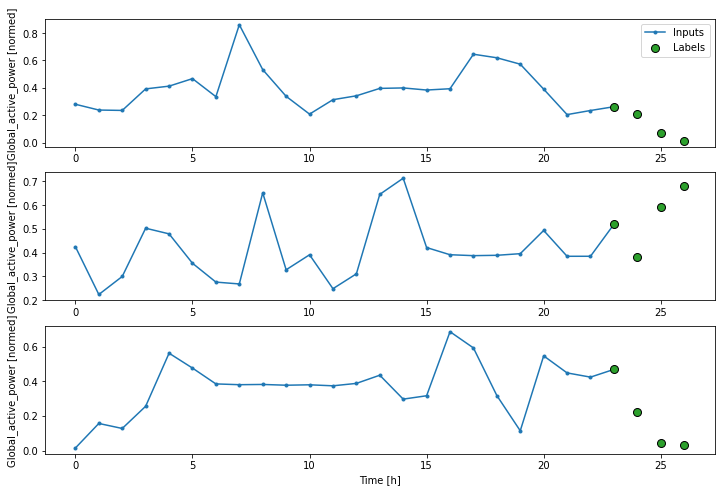

In [7]:
import IPython.display
from ppget.source import DataSource
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

A_DAY = 60 * 24
DAYS_OF_DATA = 30

# [step] marks the percentage of time advance proportional to the data cursor [size]
source = DataSource("./data/household_power_consumption.txt", size=DAYS_OF_DATA * A_DAY, step=0.33)


series = source.__next__().frame
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(series.values)
series["Global_active_power"] = x_scaled

c1 = int(len(series) * 0.7)
c2 = int(len(series) * 0.9)
train = series[:c1]
val = series[c1:c2]
test = series[c2:]

class WindowGenerator:

    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        self._example = None

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result


    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True, batch_size=4)

        ds = ds.map(self.split_window)

        return ds

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col="Global_active_power", max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

    def __repr__(self):
            return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
LENGTH = 24
OUT_STEPS = 4
w = WindowGenerator(LENGTH, OUT_STEPS, 3, train, val, test, ["Global_active_power"])
w.plot()

In [8]:
for example_inputs, example_labels in w.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (4, 24, 1)
Labels shape (batch, time, features): (4, 4, 1)


30/30 [==============================] - 0s 2ms/step - loss: 0.0638 - mean_absolute_error: 0.2007


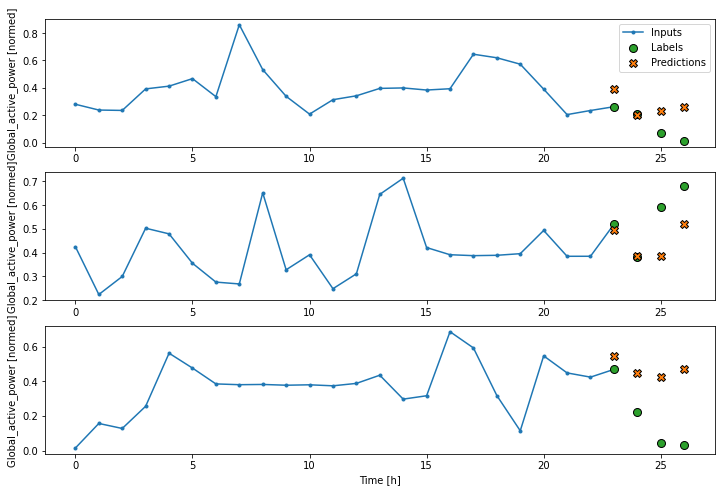

In [10]:
class Baseline(tf.keras.Model):
    def call(self, inputs):
        return inputs[:,LENGTH-OUT_STEPS:,:]

baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

performance = {}

performance['Baseline'] = baseline.evaluate(w.val)
performance['Baseline'] = baseline.evaluate(w.test, verbose=0)

w.plot(baseline)

In [15]:
CONV_WIDTH = 20

multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(512, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS * 1,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=4):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

h = compile_and_fit(multi_conv_model, w)

Epoch 1/200
120/120 [==============================] - 2s 4ms/step - loss: 0.0383 - mean_squared_error: 0.0383 - val_loss: 0.0315 - val_mean_squared_error: 0.0315
Epoch 2/200
120/120 [==============================] - 0s 4ms/step - loss: 0.0219 - mean_squared_error: 0.0219 - val_loss: 0.0233 - val_mean_squared_error: 0.0233
Epoch 3/200
120/120 [==============================] - 0s 4ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - val_loss: 0.0201 - val_mean_squared_error: 0.0201
Epoch 4/200
120/120 [==============================] - 0s 3ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.0246 - val_mean_squared_error: 0.0246
Epoch 5/200
120/120 [==============================] - 0s 3ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 6/200
120/120 [==============================] - 0s 3ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 7/200
120/120 [=

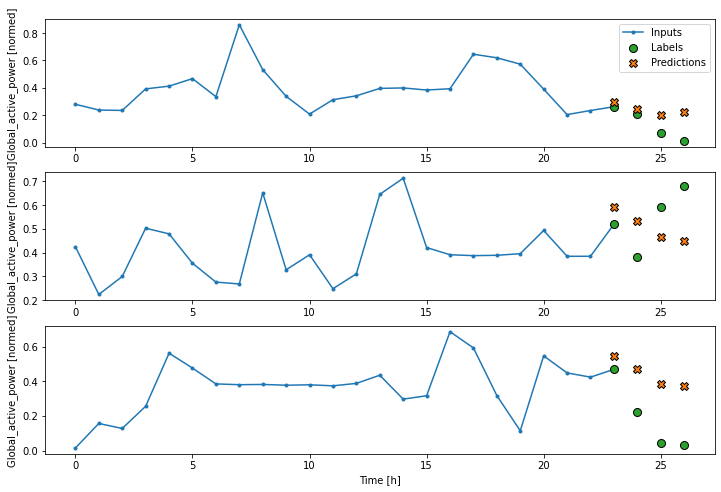

In [16]:
w.plot(multi_conv_model)

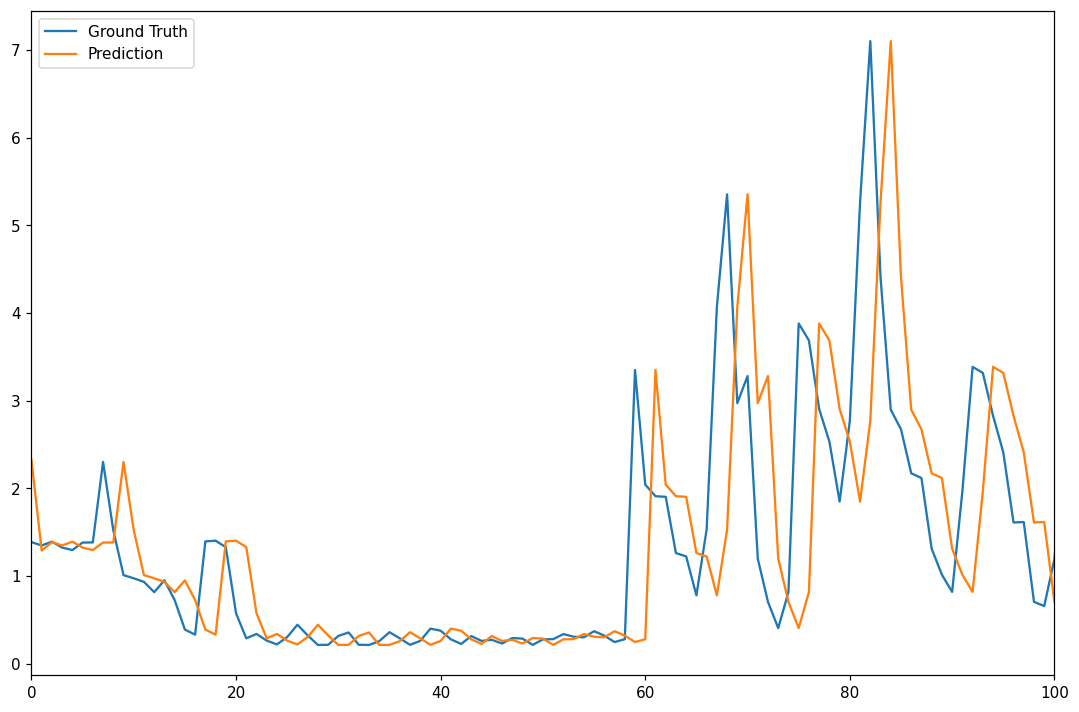

In [157]:
report_results(y_test, predictions, [0, 100])

In [156]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predictions)
print(f"R2: {r2}")

R2: 0.513191600620768
